In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from my_lib_optim_lab_2 import optimization, oracles, plot_trajectory_2d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

In [35]:
A = np.array([[1.0, 2.0], [2.0, 7.0]])
b = np.array([-1.0, 10.0])
matvec = lambda x: A @ x
oracle = oracles.QuadraticOracle(A, b)
x_0 = np.array([25.0, -5.0])

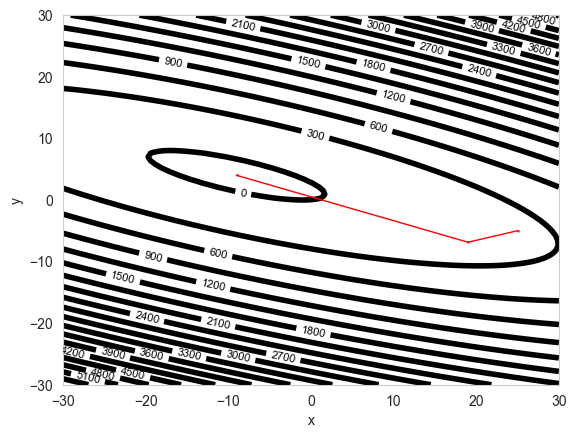

In [36]:
[x_star, msg, history] = optimization.conjugate_gradients(matvec, b, x_0, trace=True, max_iter=1000000)
plot_trajectory_2d.plot_levels(oracle.func)
plot_trajectory_2d.plot_trajectory(oracle.func, history['x'])
plt.show()

In [45]:
def create_matrix(size: int, condition_number: int):
    vec = np.concatenate(
        (np.array([1]), np.random.randint(1, condition_number + 1, size=size - 2), np.array([condition_number])))
    return scipy.sparse.diags(vec, 0) / condition_number


def create_grid(max_k: int, shape: tuple, n_reps: int):
    n_range = 2 ** np.arange(2, 2 * (shape[0]) + 1, step=2)
    k_range = np.repeat(np.linspace(10, max_k, num=shape[1], dtype=int), n_reps)
    return np.array([[(n, k) for k in k_range] for n in n_range])


def return_n_iter(value, i: int, j: int, line_search_options):
    A = create_matrix(*value)
    b = np.random.randn(value[0])
    matvec = lambda x: A @ x

    local_oracle = oracles.QuadraticOracle(A, b)
    [_, msg, history] = optimization.conjugate_gradients(matvec, b, 1 + np.random.randn(value[0]), trace=True,
                                                         max_iter=10000, tolerance=1e-9)
    if msg == 'success':
        return i, j, len(history['x'])
    else:
        return i, j, -1


def my_gen(grid, i_size, j_size, line_search_options=None):
    if line_search_options is None:
        line_search_options = {'method': 'Constant', 'c': 1.05}

    for i in range(i_size):
        for j in range(j_size):
            yield grid[i, j], i, j, line_search_options


In [46]:
from joblib import Parallel, delayed

grid_size = (5, 100)
num_reps = 10

values_matrix = np.zeros((grid_size[0], grid_size[1] * num_reps))
my_grid = create_grid(1000, grid_size, num_reps)

In [47]:
gen = my_gen(my_grid, grid_size[0], grid_size[1] * num_reps)

result = Parallel(n_jobs=8, verbose=10)(delayed(return_n_iter)(*x) for x in gen)

for i, j, v in result:
    values_matrix[i, j] = v

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.18462708398068936s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.06274223327636719s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.06347775459289551s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done 100 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Batch computation too fast (0.06420063972473145s.) Setting batch_size=16.
[Parallel(n_jobs=8)]: Done 160 tasks      | elapsed:    

In [48]:
values_matrix

array([[  5.,   5.,   5., ...,   5.,   5.,   5.],
       [ 10.,   7.,  10., ...,  17.,  17.,  17.],
       [ 11.,  11.,  11., ...,  37.,  42.,  43.],
       [ 11.,  11.,  11., ...,  64.,  66.,  69.],
       [ 11.,  11.,  11., ..., 114., 117., 100.]])

Text(0.5, 1.0, 'Conjugate gradient method')

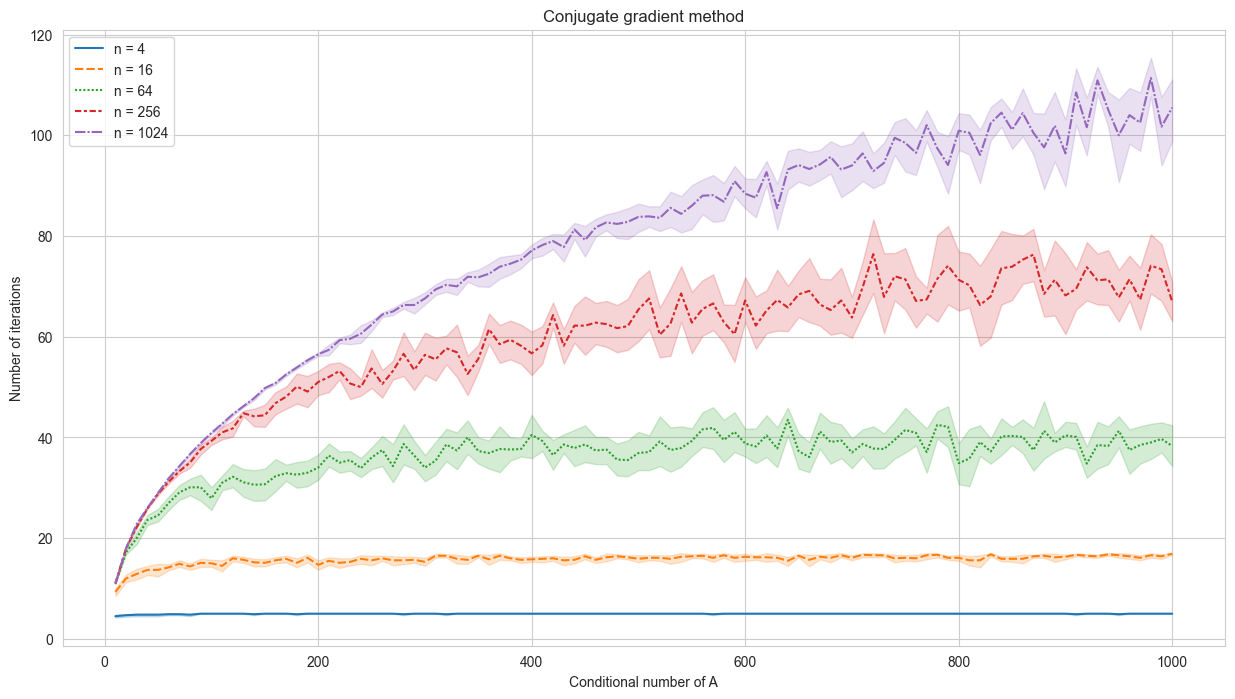

In [49]:
data = pd.DataFrame(values_matrix.T, columns=[f'n = {n}' for n in my_grid[:, 1, 0]],
                    index=[int(n) for n in my_grid[-1, :, -1]])
plt.figure(figsize=(15, 8))
ax = sns.lineplot(data)
ax.set(xlabel='Conditional number of A', ylabel='Number of iterations')
plt.title(r"Conjugate gradient method")

In [3]:
from sklearn.datasets import load_svmlight_file

dataset_w8a = load_svmlight_file(r'../Lab 1/datasets/w8a.txt')
dataset_gisette = load_svmlight_file(r'../Lab 1/datasets/gisette_scale')
dataset_real_sim = load_svmlight_file(r'../Lab 1/datasets/real-sim')
dataset_rcv_1 = load_svmlight_file(r'../Lab 1/datasets/rcv1_test.binary')
dataset_news20 = load_svmlight_file(r'../Lab 1/datasets/news20.binary')

In [4]:
def fun_for_plot(dataset, name: str):
    X, y = dataset[0], dataset[1]
    reg_coeff = 1 / y.shape[0]
    x_0 = np.zeros(X.shape[1])
    oracle = oracles.create_log_reg_oracle(X, y, regcoef=reg_coeff)
    X, msg, history = optimization.gradient_descent(oracle, trace=True, x_0=x_0,
                                                    line_search_options={'method': 'Wolfe'}, max_iter=10 ** 10)
    X_neut, msg_neut, history_neut = optimization.hessian_free_newton(oracle, trace=True, x_0=x_0, tolerance=1e-9,
                                                                      line_search_options={'method': 'Wolfe'},
                                                                      max_iter=10 ** 10)
    X_lbfgs, msg_lbfgs, history_lbfgs = optimization.lbfgs(oracle, trace=True, x_0=x_0, tolerance=1e-9,
                                                           line_search_options={'method': 'Wolfe'},
                                                           max_iter=10 ** 10)

    data_for_graph = pd.DataFrame(
        [history['time'], history_neut['time'], history_lbfgs['time'], history['func'], history_neut['func'],
         history_lbfgs['func'], np.array(history['grad_norm'] / history['grad_norm'][0]) ** 2,
         np.array(history_neut['grad_norm'] / history_neut['grad_norm'][0]) ** 2,
         np.array(history_lbfgs['grad_norm'] / history_lbfgs['grad_norm'][0]) ** 2, np.arange(len(history['time'])),
         np.arange(len(history_neut['time'])), np.arange(len(history_lbfgs['time']))])
    data_for_graph = data_for_graph.T
    data_for_graph.columns = ['time_grad', 'time_neut', 'time_lbfgs', 'func_grad', 'func_neut', 'func_lbfgs',
                              'norm_grad', 'norm_neut', 'norm_lbfgs', 'iter_grad', 'iter_neut', 'iter_lbfgs']

    fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    sns.lineplot(data=data_for_graph, x='time_grad', y='func_grad', label='Gradient descent', ax=axis[0])
    sns.lineplot(data=data_for_graph, x='time_neut', y='func_neut', label='Newton', ax=axis[0])
    sns.lineplot(data=data_for_graph, x='time_lbfgs', y='func_lbfgs', label='lbfgs', ax=axis[0])
    axis[0].set(xlabel='Time, s', ylabel='Function value')

    sns.lineplot(data=data_for_graph, x='iter_grad', y='func_grad', label='Gradient descent', ax=axis[1])
    sns.lineplot(data=data_for_graph, x='iter_neut', y='func_neut', label='Newton', ax=axis[1])
    sns.lineplot(data=data_for_graph, x='iter_lbfgs', y='func_lbfgs', label='lbfgs', ax=axis[1])

    axis[1].set(xlabel='Number of iteration', ylabel='Function value')

    sns.lineplot(data=data_for_graph, x='time_grad', y='norm_grad', label='Gradient descent', ax=axis[2])
    sns.lineplot(data=data_for_graph, x='time_neut', y='norm_neut', label='Newton', ax=axis[2])
    sns.lineplot(data=data_for_graph, x='time_lbfgs', y='norm_lbfgs', label='lbfgs', ax=axis[2])

    axis[2].set(xlabel='Time, s', ylabel='Relative gradient norm')
    axis[2].set_yscale('log')

    fig.suptitle(f'{name} dataset')
    plt.show()

    return data_for_graph

1.0
0.24027110291713055
0.03747072305952916
0.005870116075923631
0.001351310281164712
0.0002621833181363085
4.093569246190751e-05
3.612466745279872e-06
2.843312498868456e-07
1.92322071396943e-08
1.0
0.7637838706327063
0.1041945560803794
0.03522902766995654
0.008653773148296044
0.0024643951012211004
0.0006964884192581628
0.0002022021127307508
6.620829212967848e-05
0.00011550770865648922
2.5232681756630894e-05
1.2296302396744068e-05
7.804573692340055e-06
1.5145240005577125e-05
5.311916886162585e-06
1.8547101444204584e-06
1.6488232325797045e-06
3.641278513785109e-06
1.2273381079694169e-06
6.823171710073946e-07
4.2157320416933296e-07
1.6623635912629234e-06
5.863469138463371e-07
2.311101077619937e-07
1.6364476452390128e-07
1.1822310733847553e-07
1.483786436926159e-06
5.680570485110712e-08
3.4020613102857934e-08
6.260336397883828e-08
4.927799887551074e-08
2.3229944333479712e-08
1.1252694100984103e-08
3.3066925922119255e-08
3.4822342823825544e-08
5.702556821030375e-09
6.209702872897613e-09
6.

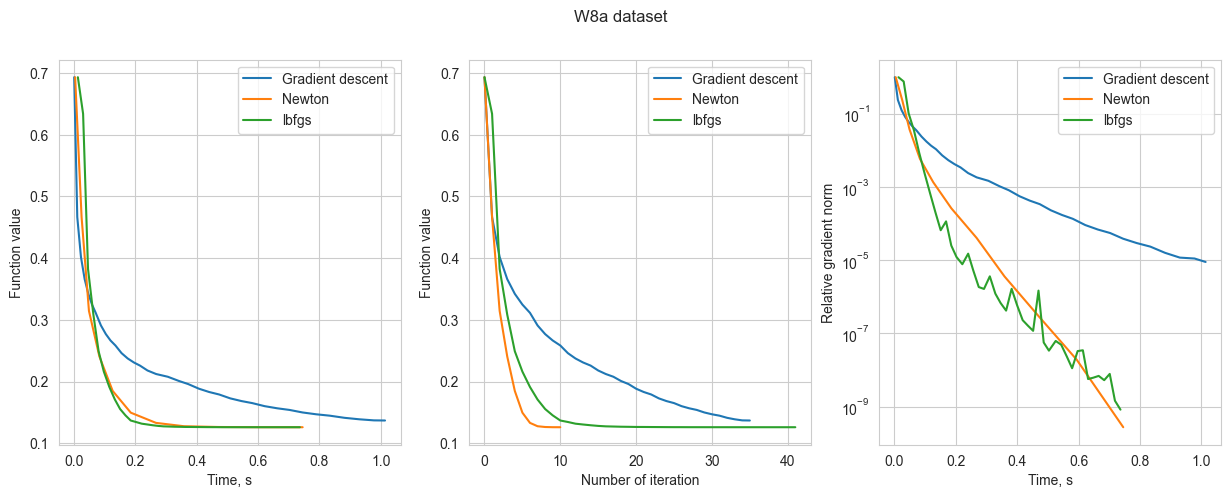

In [69]:
w8a_data = fun_for_plot(dataset_w8a, 'W8a')

1.0
0.18669998924789674
0.01642312695802968
0.0038839550162575198
0.0005879597216406951
0.00017302619661074638
2.5507177614884533e-05
3.644186635301651e-06
6.89505793480282e-06
3.9895058179815867e-07
1.3487817371514159e-08
1.0
34.81815866782173
0.9940498905717653
0.11306511188746673
0.12104802429878996
0.16081592420557517
0.10176793309514275
0.061971778866953445
0.12889432707468992
0.1257910036555405
0.2961409296897168
0.08260618632680655
0.022160199131446193
0.0076747682306590225
0.003622964978484421
0.0019328360600594154
0.0010211539569189288
0.009224732867197443
0.0011170582825508785
0.0006948101880314315
0.0003562112742649575
0.003686196793183495
0.001732127450705418
0.001113692810961042
0.0003884392118232499
0.0001372552116933061
7.22858622044602e-05
5.640686778189026e-05
0.0001710209461991161
0.0004676083051222254
2.450974381918515e-05
7.695100069579378e-06
5.775989419512305e-05
1.404128756113489e-05
5.257995005657654e-06
3.973141563702278e-06
5.177267361834908e-05
3.473294679829

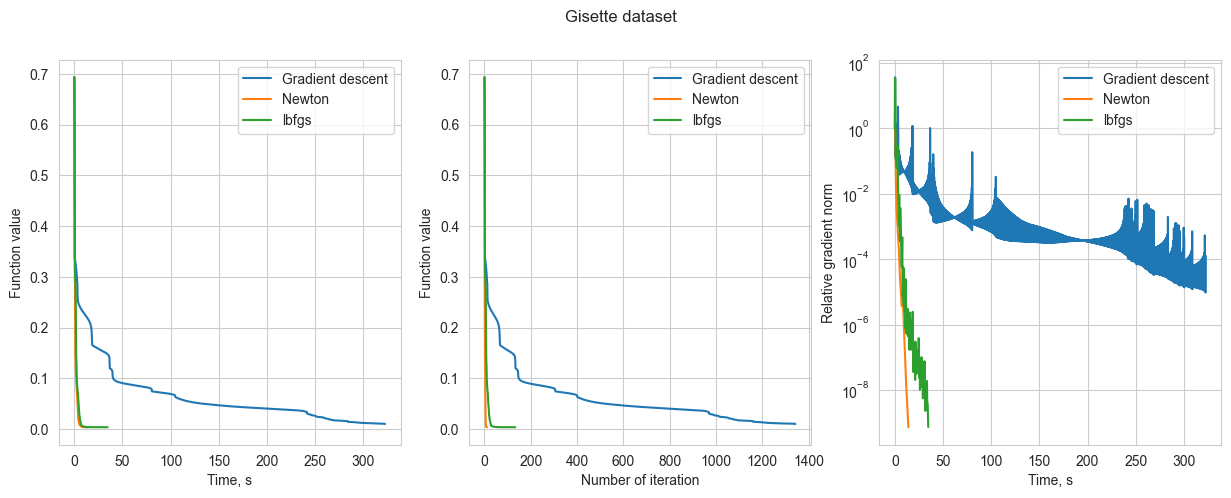

In [70]:
gisette_data = fun_for_plot(dataset_gisette, 'Gisette')

E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


1.0
0.08756361476570622
0.009943176471911747
0.001006682871456981
5.188595201426302e-05
3.231079110826047e-07
1.0
0.7811474767628753
0.09469021045547284
0.031088580249928208
0.007376267226999012
0.003128676408908952
0.00037600094457585984
0.00020975991330774422
0.0002352640136830245
7.983491817644897e-05
3.202826831968648e-05
9.925243459391279e-06
6.302001912570452e-06
1.7575319475465519e-06
4.333285768752827e-07
1.8623545662433413e-07
7.214551798150588e-07
2.8038096686981775e-07
2.0715519891562105e-08
1.2001640108656692e-08
6.086918592683785e-09
2.563306463994588e-09
1.8405225128598045e-09


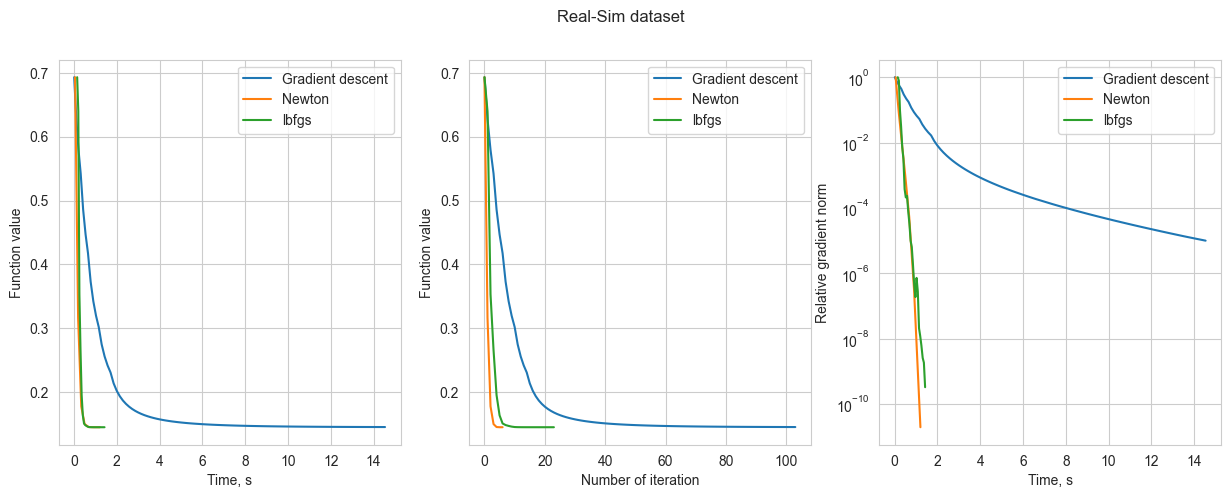

In [71]:
real_sim_data = fun_for_plot(dataset_real_sim, 'Real-Sim')

E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


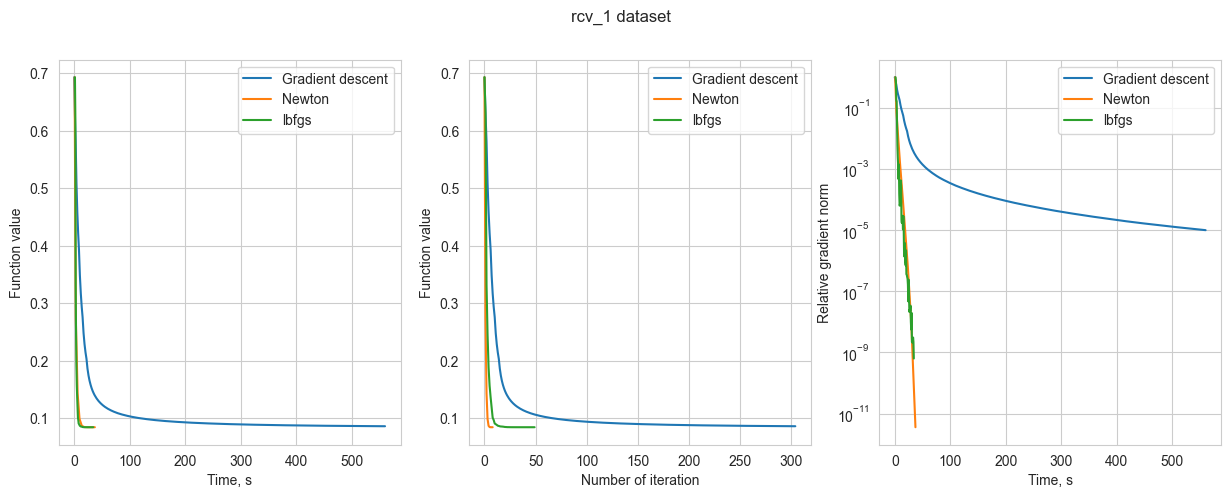

In [5]:
rcv_1_data = fun_for_plot(dataset_rcv_1, 'rcv_1')

E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


1.0
0.04176247713907229
0.0014478060997673335
5.930585526470516e-06
1.0
0.7875368403486773
7.645870948539897
0.18050631362918607
0.10159753290148898
0.19766801405550202
0.3003280408974861
0.13328939286731517
0.012829483938061348
0.006533766990545183
0.007412246389202067
0.00192599434819413
0.0002925052308929821
9.268656512224326e-05
3.5198751734856774e-05
2.457936560676223e-05
9.842738332943319e-06
9.332443772465721e-06
1.0923757403770533e-06
5.996886893734311e-07
1.3084286270389164e-07
1.4012518159395704e-08
2.8408416561937915e-08
4.996614151611261e-09


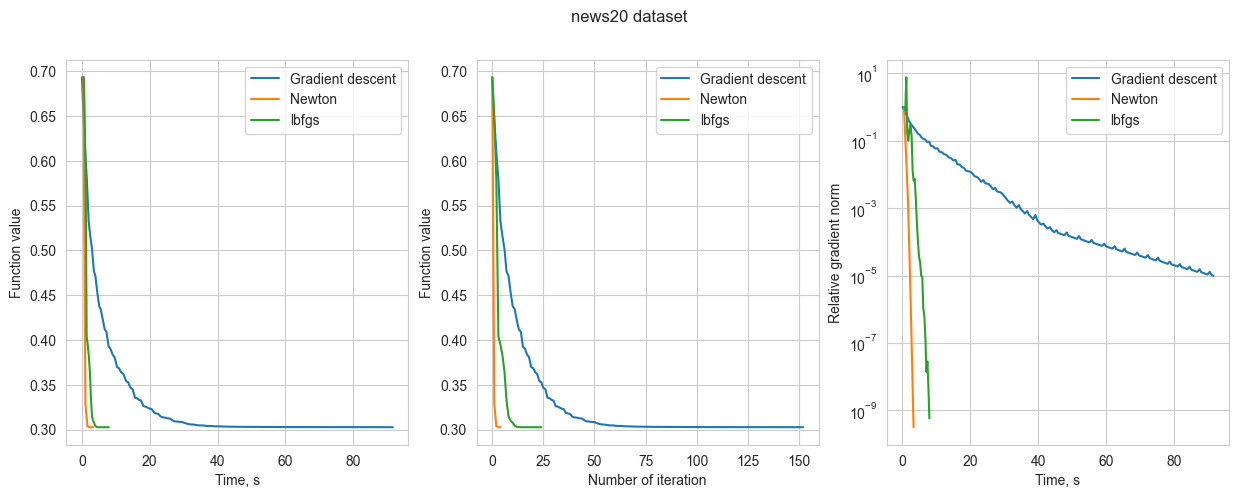

In [74]:
news20_data = fun_for_plot(dataset_news20, 'news20')

In [92]:
def fun_for_plot_second(dataset, name: str, data=None):
    if data is None:
        X, y = dataset[0], dataset[1]
        reg_coeff = 1 / y.shape[0]
        x_0 = np.zeros(X.shape[1])
        oracle = oracles.create_log_reg_oracle(X, y, regcoef=reg_coeff)
        X_0, msg_0, history_0 = optimization.lbfgs(oracle, trace=True, x_0=x_0, tolerance=1e-4,
                                                   line_search_options={'method': 'Wolfe'},
                                                   max_iter=10 ** 10, memory_size=0)
        X_1, msg_0, history_1 = optimization.lbfgs(oracle, trace=True, x_0=x_0, tolerance=1e-9,
                                                   line_search_options={'method': 'Wolfe'},
                                                   max_iter=10 ** 10, memory_size=1)
        X_5, msg_5, history_5 = optimization.lbfgs(oracle, trace=True, x_0=x_0, tolerance=1e-9,
                                                   line_search_options={'method': 'Wolfe'},
                                                   max_iter=10 ** 10, memory_size=5)
        X_10, msg_10, history_10 = optimization.lbfgs(oracle, trace=True, x_0=x_0, tolerance=1e-9,
                                                      line_search_options={'method': 'Wolfe'},
                                                      max_iter=10 ** 10, memory_size=10)
        X_50, msg_50, history_50 = optimization.lbfgs(oracle, trace=True, x_0=x_0, tolerance=1e-9,
                                                      line_search_options={'method': 'Wolfe'},
                                                      max_iter=10 ** 10, memory_size=50)
        X_100, msg_100, history_100 = optimization.lbfgs(oracle, trace=True, x_0=x_0, tolerance=1e-9,
                                                         line_search_options={'method': 'Wolfe'},
                                                         max_iter=10 ** 10, memory_size=10)

        data_for_graph = pd.DataFrame(
            [history_0['time'], history_1['time'], history_5['time'], history_10['time'], history_50['time'],
             history_100['time'],
             np.arange(len(history_0['time'])), np.arange(len(history_1['time'])), np.arange(len(history_5['time'])),
             np.arange(len(history_10['time'])), np.arange(len(history_50['time'])),
             np.arange(len(history_100['time'])),
             np.array(history_0['grad_norm'] / history_0['grad_norm'][0]) ** 2,
             np.array(history_1['grad_norm'] / history_1['grad_norm'][0]) ** 2,
             np.array(history_5['grad_norm'] / history_5['grad_norm'][0]) ** 2,
             np.array(history_10['grad_norm'] / history_10['grad_norm'][0]) ** 2,
             np.array(history_50['grad_norm'] / history_50['grad_norm'][0]) ** 2,
             np.array(history_100['grad_norm'] / history_100['grad_norm'][0]) ** 2])
        data_for_graph = data_for_graph.T
        data_for_graph.columns = ['time_0', 'time_1', 'time_5', 'time_10', 'time_50', 'time_100', 'iter_0', 'iter_1',
                                  'iter_5', 'iter_10', 'iter_50', 'iter_100', 'norm_0', 'norm_1', 'norm_5', 'norm_10',
                                  'norm_50', 'norm_100']
    else:
        data_for_graph = data
    fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    sns.lineplot(data=data_for_graph, x='time_0', y='norm_0', label='memory_size=0', ax=axis[0])
    sns.lineplot(data=data_for_graph, x='time_1', y='norm_1', label='memory_size=1', ax=axis[0])
    sns.lineplot(data=data_for_graph, x='time_5', y='norm_5', label='memory_size=5', ax=axis[0])
    sns.lineplot(data=data_for_graph, x='time_10', y='norm_10', label='memory_size=10', ax=axis[0])
    sns.lineplot(data=data_for_graph, x='time_50', y='norm_50', label='memory_size=50', ax=axis[0])
    sns.lineplot(data=data_for_graph, x='time_100', y='norm_100', label='memory_size=100', ax=axis[0])

    axis[0].set(xlabel='Time, s', ylabel='Relative gradient norm')
    axis[0].set_yscale('log')

    sns.lineplot(data=data_for_graph, x='iter_0', y='norm_0', label='memory_size=0', ax=axis[1])
    sns.lineplot(data=data_for_graph, x='iter_1', y='norm_1', label='memory_size=1', ax=axis[1])
    sns.lineplot(data=data_for_graph, x='iter_5', y='norm_5', label='memory_size=5', ax=axis[1])
    sns.lineplot(data=data_for_graph, x='iter_10', y='norm_10', label='memory_size=10', ax=axis[1])
    sns.lineplot(data=data_for_graph, x='iter_50', y='norm_50', label='memory_size=50', ax=axis[1])
    sns.lineplot(data=data_for_graph, x='iter_100', y='norm_100', label='memory_size=100', ax=axis[1])

    axis[1].set(xlabel='Number of iteration', ylabel='Relative gradient norm')
    axis[1].set_yscale('log')

    fig.suptitle(f'L-BFGS on {name} dataset')
    plt.show()

    return data_for_graph

E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
E:\Python_Interpeter_1.12\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


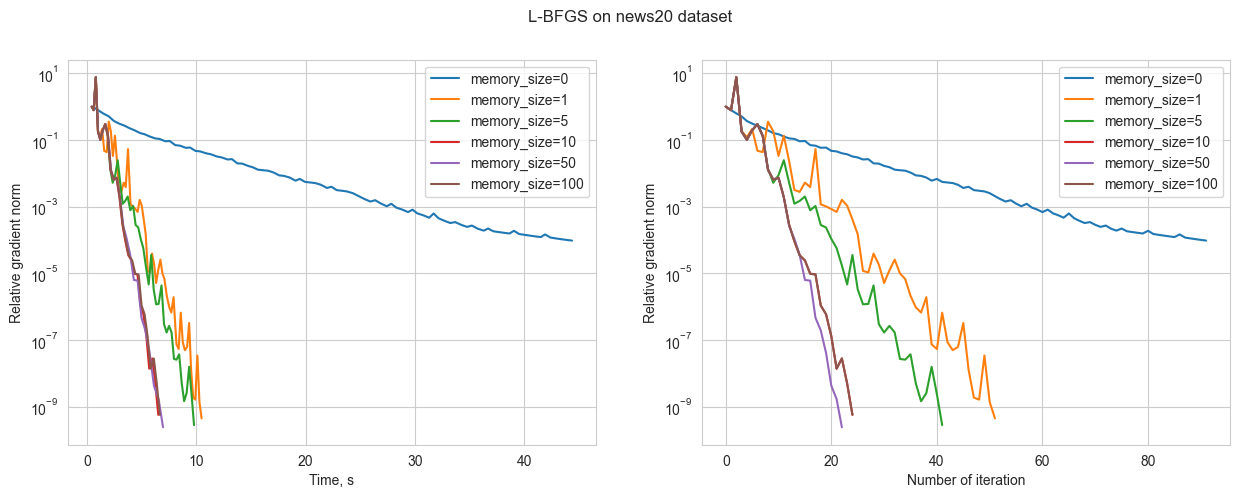

In [94]:
news20_data = fun_for_plot_second(dataset_news20, 'news20')

In [4]:
from my_lib_optim_lab_2.oracles import hess_vec_finite_diff
from sklearn.datasets import load_svmlight_file
dataset_w8a = load_svmlight_file(r'../Lab 1/datasets/w8a.txt')
X, y = dataset_w8a[0], dataset_w8a[1]
reg_coeff = 1 / y.shape[0]
x_0 = np.zeros(X.shape[1])
oracle = oracles.create_log_reg_oracle(X, y, regcoef=reg_coeff)

In [7]:
v = np.random.rand(*x_0.shape)

In [14]:
np.max(hess_vec_finite_diff(oracle, x_0, v) - np.squeeze(oracle.hess_vec(x_0, v)))

1.5320457154022193e-05